<a href="https://colab.research.google.com/github/arosha27/DeepLearningProjects/blob/main/MonthlyBirthRateInScotland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHASE 1: Data Acquisition

### 1.1: Install and Import Required Libraries

In [10]:
# Install required libraries if not already installed
!pip install openpyxl optuna holidays

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import holidays
import warnings
warnings.filterwarnings("ignore")

### 1.2: Mount Google Drive

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.3: Create the Folder Structure

In [32]:
import os
base_path = "/content/drive/MyDrive/BirthRateForecastingProject"

folders= ["data" ,
          "models/baseline" ,
          "models/deeplearning" ,
          "outputs/plot_and_results"]

for folder in folders:
    path = os.path.join(base_path, folder)
    os.makedirs(path, exist_ok=True)

print("📁 Folder structure created successfully!")

📁 Folder structure created successfully!


### 1.4: Move Your Data File to the data/ Folder

In [34]:
import shutil
shutil.move("/content/monthly_births_table_1.csv" ,
            f"{base_path}/data/monthly_births_table_1.csv")

'/content/drive/MyDrive/BirthRateForecastingProject/data/monthly_births_table_1.csv'

# Phase 2 : Data Preprocessing

**Data Preparation Instructions:**

From the proposal, the Data Preparation step includes:

1. Use monthly birth registrations (from Table 1)

2. Extract data from Jan 1998 to Dec 2022

3. Apply log transformation to stabilize variance

4. Split into:

  Train (1998–2018)

  Validation (2019–2020)

  Test (2021–2022)

### 2.1 Load Data From Google Drive

In [35]:
import pandas as pd

# Load the cleaned and moved Table_1 file
file_path = "/content/drive/MyDrive/BirthRateForecastingProject/data/monthly_births_table_1.csv"

# Load the sheet (adjust skiprows if needed)
df = pd.read_csv(file_path)

# Show first few rows
df.head(20)


,Year,Month,NHS Board area,Births registered
0,2025,June,Ayrshire and Arran,273
1,2025,June,Borders,64
2,2025,June,Dumfries and Galloway,82
3,2025,June,Fife,242
4,2025,June,Forth Valley,195
5,2025,June,Grampian,346
6,2025,June,Greater Glasgow and Clyde,899
7,2025,June,Highland,184
8,2025,June,Lanarkshire,546
9,2025,June,Lothian,618


### 2.2 Clean, Convert Date, Filter (1998–2022), Aggregate

**Based on proposal , things we need to do :**
1. Create a proper datetime column combining Year + Month

2. Filter only rows from Jan 1998 to Dec 2022

3. For each month, sum all NHS Board areas (excluding “Scotland” if it's a duplicate total)

4. Create a clean monthly time series of total births

5. Apply log transformation

6. Prepare splits: Train (1998–2018), Validation (2019–2020), Test (2021–2022)

In [36]:
# Combine 'Year' and 'Month' into a

df["Date"] = pd.to_datetime(df["Year"].astype(str) + " " + df["Month"] ,
                            format = '%Y %B')
df.head()

,Year,Month,NHS Board area,Births registered,Date
0,2025,June,Ayrshire and Arran,273,2025-06-01
1,2025,June,Borders,64,2025-06-01
2,2025,June,Dumfries and Galloway,82,2025-06-01
3,2025,June,Fife,242,2025-06-01
4,2025,June,Forth Valley,195,2025-06-01


In [37]:
#Filter for Jan 1998 to Dec 2022
df = df[(df['Date'] >= '1998-01-01') & (df['Date'] <= '2022-12-31')]

In [42]:
df.sample(2)

,Year,Month,NHS Board area,Births registered,Date
2983,2008,November,Shetland,20,2008-11-01
2217,2013,February,Scotland,4332,2013-02-01


In [43]:
#Remove any rows where 'NHS Board area' is 'Scotland' (to avoid double counting)
df = df[df['NHS Board area'] != 'Scotland']

In [52]:
#Group by date and sum total births across all NHS Board areas
monthly_births = df.groupby('Date')['Births registered'].sum().reset_index()

,Date,Births registered
0,1998-01-01,4924
1,1998-02-01,4308
2,1998-03-01,4919
3,1998-04-01,4807
4,1998-05-01,4485
...,...,...
295,2022-08-01,4054
296,2022-09-01,4052
297,2022-10-01,4329
298,2022-11-01,4498


In [54]:
#Rename for clarity
monthly_births.rename(columns={'Births registered': 'total_births'}, inplace=True)

# Preview
print("Final monthly time series shape:", monthly_births.shape)
monthly_births.head()

Final monthly time series shape: (300, 2)


,Date,total_births
0,1998-01-01,4924
1,1998-02-01,4308
2,1998-03-01,4919
3,1998-04-01,4807
4,1998-05-01,4485


### 2.3 Log Transform & Create Train/Val/Test Splits

In [56]:
import numpy as np
monthly_births["log_births"] = np.log1p(monthly_births["total_births"])
monthly_births.sample(2)

,Date,total_births,log_births
21,1999-10-01,4503,8.412721
77,2004-06-01,4706,8.456806


### Why log tranformation is needed?

* **Log transformation** is used to reduce large differences in the data, especially when some values are much bigger than others.
* It helps the model focus on **patterns and trends** instead of just big numbers.
* This makes the data easier for the model to learn from and leads to **better and more accurate predictions**.



In [59]:
#  Create splits
train = monthly_births[(monthly_births['Date'] >= '1998-01-01') & (monthly_births['Date'] <= '2018-12-31')]
val   = monthly_births[(monthly_births['Date'] >= '2019-01-01') & (monthly_births['Date'] <= '2020-12-31')]
test  = monthly_births[(monthly_births['Date'] >= '2021-01-01') & (monthly_births['Date'] <= '2022-12-31')]


# Print sizes
print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (252, 3)
Validation shape: (24, 3)
Test shape: (24, 3)


 ### 2.4 Plot Raw vs. Log-Transformed Series

Text(0, 0.5, 'log(Births)')

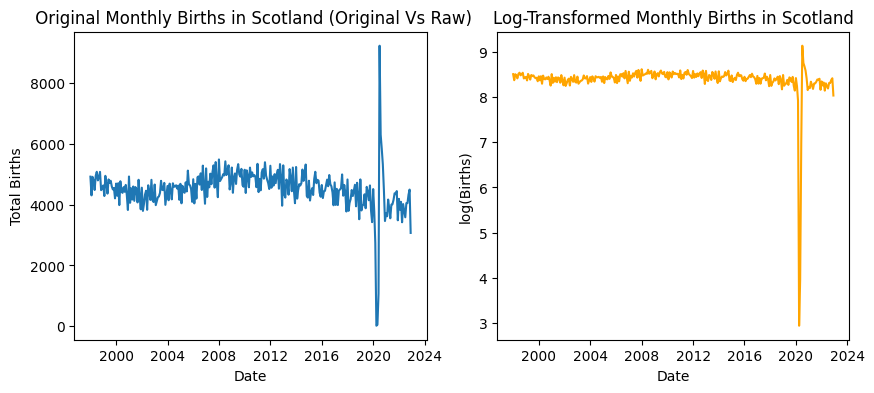

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(monthly_births["Date"] , monthly_births["total_births"] , label = "Raw Births")
plt.xlabel("Date")
plt.ylabel("Total Births")
plt.title(" Original Monthly Births in Scotland (Original Vs Raw)")

plt.subplot(1,2,2)
plt.plot(monthly_births['Date'], monthly_births['log_births'], color='orange')
plt.title("Log-Transformed Monthly Births in Scotland")
plt.xlabel("Date")
plt.ylabel("log(Births)")


In [73]:
monthly_births[(monthly_births['Date'] >= '2019-01-01') & (monthly_births['Date'] <= '2021-12-31')]


,Date,total_births,log_births
252,2019-01-01,4833,8.483430
253,2019-02-01,3812,8.246172
254,2019-03-01,3973,8.287528
255,2019-04-01,3999,8.294050
256,2019-05-01,4343,8.376551
257,2019-06-01,3884,8.264878
258,2019-07-01,4588,8.431417
259,2019-08-01,4417,8.393442
260,2019-09-01,4147,8.330382
261,2019-10-01,4635,8.441607


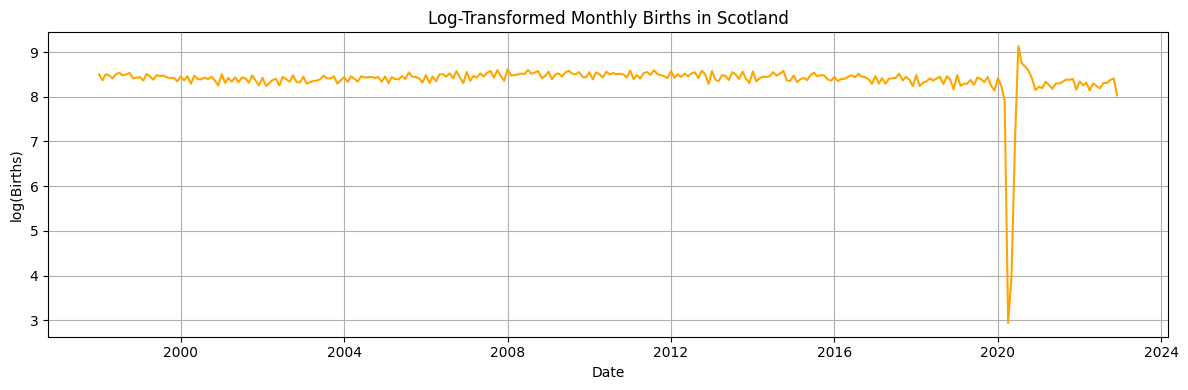